In [642]:
import json
import requests
from datetime import timedelta, datetime
from operator import itemgetter
import pandas as pd
from sklearn import linear_model, metrics
from sklearn import preprocessing
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

def createOlapPayload(sources,metrics,dimensions,startDate,endDate,filters):
	data = {}
	data['sources'] = sources
	data['metrics'] = metrics
	i = 1
	dimensionsDict = {}
	for dimension in dimensions:
		dimensionsDict[dimension] = i
		i += 1
	data['dimensions'] = dimensionsDict
	date1 = datetime.strptime(startDate,'%Y-%m-%d').strftime("%Y-%m-%d")
	date2 = (datetime.strptime(endDate,'%Y-%m-%d') + timedelta(1)).strftime("%Y-%m-%d")
	segments = []
	segmentsDict = {}
	segmentsDict['dateStart'] = "{0}T00:00:00+03:00".format(date1)
	segmentsDict['dateEnd'] = "{0}T00:00:00+03:00".format(date2)
	segmentsDict['filters'] = {}
	for filterKey, filterValue in filters.iteritems():
		segmentsDict['filters'][filterKey] = {}
		segmentsDict['filters'][filterKey]['type'] = 'DIMENSION'
		segmentsDict['filters'][filterKey]['ids'] = filterValue
	segments.append(segmentsDict)
	data['segments'] = segments
	return data

def getJSONOlapResponse(data):
	url = 'http://192.168.10.5:4000/api/OLAP/Plain'
	headers = {'Content-Type': 'application/json'}
	response = requests.post(url,data,headers=headers)
	return json.loads(response.text)

def transformOlapResponse(response,payload):
	data = []
	dimensionsList = [{'key': k, 'value': v} for k,v in payload['dimensions'].iteritems()]
	dimensionsList = sorted(dimensionsList, key=itemgetter('value'))
	for item in response:
		i = 0
		dataDict = {}
		for dimensionValue in item['dimensions']:
			dimensionName = dimensionsList[i]['key']
			dataDict[dimensionName] = dimensionValue
			i += 1
		metrics = item['value'][0]
		for k,v in metrics.iteritems():
			dataDict[k] = v
		data.append(dataDict)
	return data

# filters = {'campaignTypeId': ['1','2'], 'campaignExternalId': ['10784315']}
# source = 'direct_conversion'
# metrics = ['visits','shows','clicks','spent','cpaVisits']
# dimensions = ['dateDay','campaignExternalId','adExternalId']
# startDate = '2016-01-01'
# endDate = '2016-01-27'
# payload = createOlapPayload(source,metrics,dimensions,startDate,endDate,filters)
# response = getJSONOlapResponse(json.dumps(payload))
# data = transformOlapResponse(response,payload)

In [643]:
filters = {'campaignTypeId': ['1','2'], 'campaignExternalId': ['16056512']}
sources = ["direct_bid","direct_conversion"]
metrics = [ "countContextBid", "contextBid", "contextProbability", "contextProbability1", "contextProbability2","contextProbability3",
"contextProbability4","contextProbability5","contextPrice1","contextPrice2","contextPrice3",
"contextPrice4","contextPrice5","clicks","spent","shows"]
dimensions = ['keyPhraseName','dateDay']
startDate = '2016-02-01'
endDate = '2016-03-22'
payload = createOlapPayload(sources,metrics,dimensions,startDate,endDate,filters)
response = getJSONOlapResponse(json.dumps(payload))
data = transformOlapResponse(response,payload)
df = pd.DataFrame(data)
df['dateDay'] = pd.to_datetime(df['dateDay'])

In [687]:
experimentData = []
statDate1 = datetime(2016,2,2)
query = u'нижнее белье +для беременных'
for t in xrange(1,47):
    d = {}
    statDate2 = statDate1+timedelta(t)
    forecastDate = statDate2+timedelta(1)
    d['statDate1'] = statDate1
    d['statDate2'] = statDate2
    d['forecastDate'] = forecastDate
#     print 'Training data between {0} - {1}'.format(statDate1.strftime("%Y-%m-%d"),statDate2.strftime("%Y-%m-%d"))
#     print 'Forecasting on date: {0}'.format(forecastDate.strftime("%Y-%m-%d"))
    x = df[(df['keyPhraseName'] == query) & (df['dateDay'] >= statDate1) & (df['dateDay'] <= statDate2)][['contextBid']].as_matrix()
    y = df[(df['keyPhraseName'] == query) & (df['dateDay'] >= statDate1) & (df['dateDay'] <= statDate2)]['shows'].as_matrix()
    clf = linear_model.LassoLars(alpha=.1)
    clf2 = SVR(C=8.0, epsilon=3.4,kernel='poly',degree=2,shrinking=True)
    clf3 = linear_model.BayesianRidge()
    clf4 = KernelRidge(alpha=0.2,kernel='poly',degree=5,coef0=2.9)
    clf.fit(x,y)
    clf2.fit(x,y)
    clf3.fit(x,y)
    clf4.fit(x,y)
    d['lars'] = clf.score(x,y)
    d['svr'] = clf2.score(x,y)
    d['bayesianRidge'] = clf3.score(x,y)
    d['kernelRidge'] = clf4.score(x,y)
#     print 'LARS:',clf.score(x,y)
#     print 'SVR:',clf2.score(x,y)
#     print 'BayesianRidge:',clf3.score(x,y)
#     print 'KernelRidge:',clf4.score(x,y)
    try:
        bid = float(df[(df['keyPhraseName'] == query) & (df['dateDay'] == forecastDate)]['contextBid'])
    except TypeError:
        continue
    shows = float(df[(df['keyPhraseName'] == query) & (df['dateDay'] == forecastDate)]['shows'])
    d['bid'] = bid
    d['shows'] = shows
#     print 'Bid:',bid
#     print 'Shows:',shows
    forecast_shows = clf4.predict(bid)[0]
    if forecast_shows < 0:
         forecast_shows = clf3.predict(bid)[0]
    if forecast_shows < 0:
         forecast_shows = clf2.predict(bid)[0]
    if forecast_shows < 0:
         forecast_shows = clf.predict(bid)[0]
    forecast_shows = abs(forecast_shows)
    forecast_shows = min(df[(df['keyPhraseName'] == query) & (df['dateDay'] >= statDate1) & (df['dateDay'] <= statDate2)]['shows'].max(),forecast_shows*1.0)
    d['forecastShows'] = forecast_shows
    d['absError'] = forecast_shows-shows
    d['relError'] = forecast_shows/shows-1
#     print 'Forecasted shows:',forecast_shows
#     print 'Absolute error:',forecast_shows-shows
#     print 'Relative error:',forecast_shows/shows-1
    experimentData.append(d)
experimentDataFrame = pd.DataFrame(experimentData)
experimentDataFrame.replace([np.inf, -np.inf], np.nan, inplace=True)
m = stats.trim_mean(experimentDataFrame['relError'].dropna(), 0.1)
print m

0.0196518219223


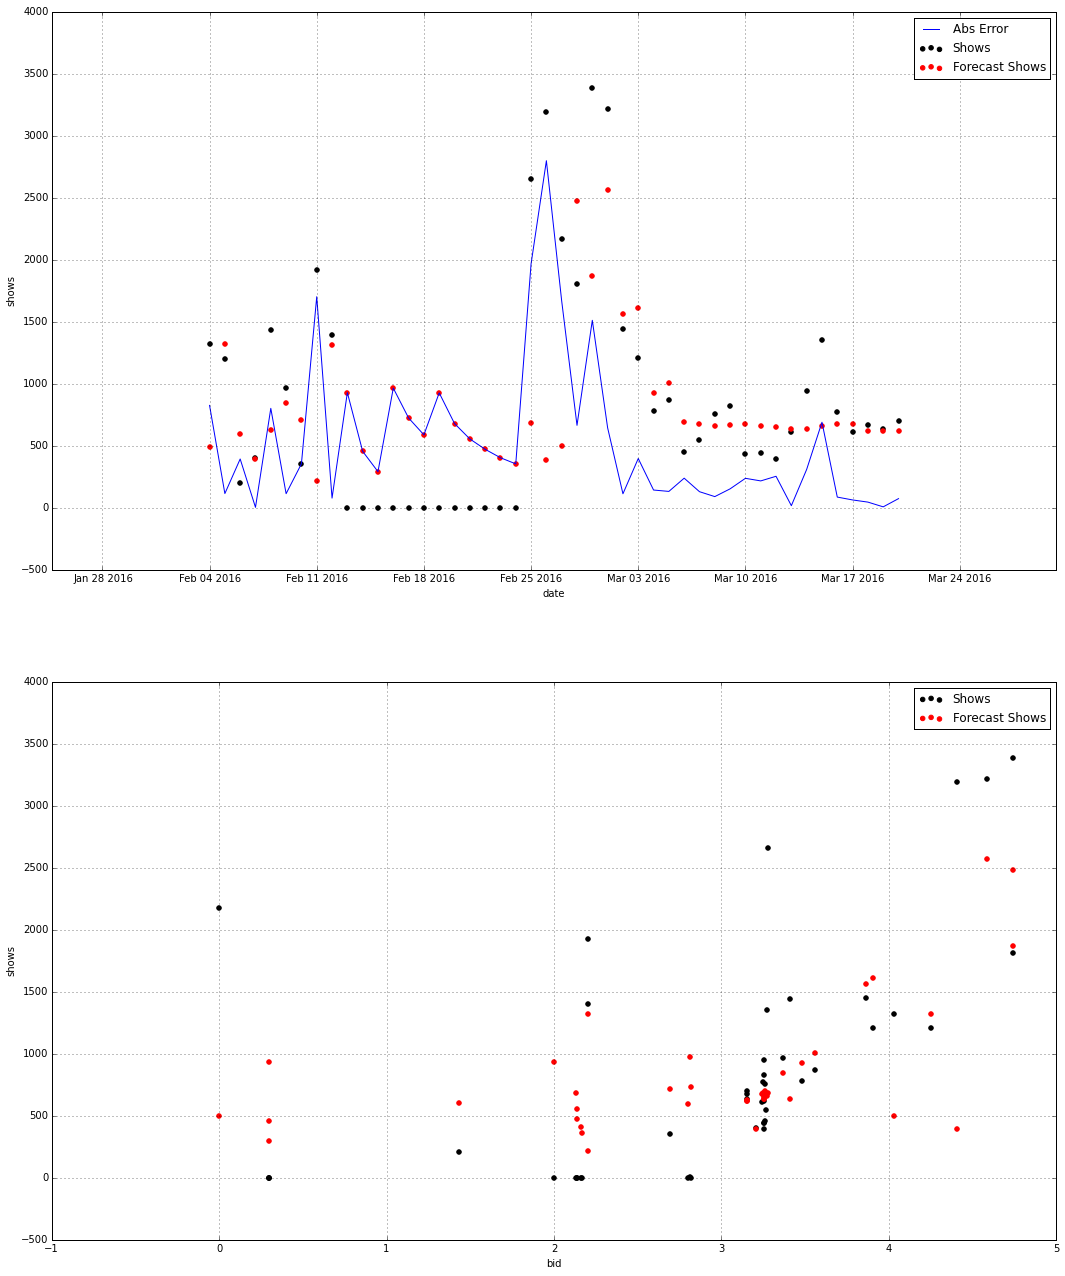

In [688]:
x = experimentDataFrame['forecastDate'].as_matrix()
y1 = experimentDataFrame['shows'].as_matrix()
y2 = experimentDataFrame['forecastShows'].as_matrix()
y3 = abs(experimentDataFrame['absError']).as_matrix()
x2 = experimentDataFrame.dropna()['forecastDate'].as_matrix()
y4 = experimentDataFrame.dropna()['relError'].as_matrix()
x3 = experimentDataFrame['bid'].as_matrix()

fig = plt.figure(figsize=(18, 22), dpi=80)
ax1 = fig.add_subplot(211)
ax1.grid(True)
ax1.scatter(x, y1,  color='black')
ax1.scatter(x, y2,  color='red')
ax1.plot (x,y3,color='blue')
ax1.axis('auto')
ax1.legend(('Abs Error','Shows','Forecast Shows'))
ax1.set_xlabel('date')
ax1.set_ylabel('shows')
ax2 = fig.add_subplot(212)
ax2.grid(True)
ax2.scatter(x3, y1,  color='black')
ax2.scatter(x3, y2,  color='red')
ax2.legend(('Shows','Forecast Shows'))
ax2.axis('auto')
ax2.set_xlabel('bid')
ax2.set_ylabel('shows')

plt.show()